In [1]:
from semanticscholar import SemanticScholar
import pickle as pkl
import csv
import json
from difflib import SequenceMatcher as sm
from tqdm.notebook import tqdm
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from os import path

from IPython.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

def get_field(p):
    if 'fieldsOfStudy' in p and p['fieldsOfStudy']:
      return p['fieldsOfStudy'][0]
    if 's2FieldsOfStudy' in p and p['s2FieldsOfStudy']:
      return p['s2FieldsOfStudy'][0]['category']

In [2]:
with open('xai-scholar.json', 'r') as f:
    papers = json.load(f)

###  Retrieve citations, references, and author information for every paper 
#### (Warning: this step takes some time and the final dictionary will be about 1 GB for papers and 2 GB for authors. Skip if you don't need them.)

In [3]:
if path.exists('xai-scholar_full.json'):
    with open('xai-scholar_full.json', 'r') as f:
        papers = json.load(f)
else:
    s2_api_key = '' # insert your SemanticScholar API key here if available
    if s2_api_key:
        ss = SemanticScholar(api_key=s2_api_key)
    else:
        ss = SemanticScholar()

    papers_full = dict()
    for pid in tqdm(papers):
        papers[pid] = dict(ss.get_paper(pid))

        if 'embedding' in papers[pid]:
            del papers[pid]['embedding']

    with open('xai-scholar_full.json', 'w') as f:
        json.dump(papers_full, f)

    papers = papers_full

In [4]:
if path.exists('xai-scholar_authors_full.json'):
    with open('xai-scholar_authors_full.json', 'r') as f:
        authors = json.load(f)
else:
    authors = {}
    for pid in tqdm(papers):
        authorlist = papers[pid]['authors'] if 'authors' in papers[pid] else []
        for author in authorlist:
            if author['authorId'] not in authors:
                try:
                    author_full = dict(ss.get_author(author['authorId']))
                except Exception as e:
                    print(author, e)
                authors[author['authorId']] = author_full
    with open('semanticscholar/xai-scholar_authors_full.json', 'w') as f:
        json.dump(authors, f)   

### Growth trends

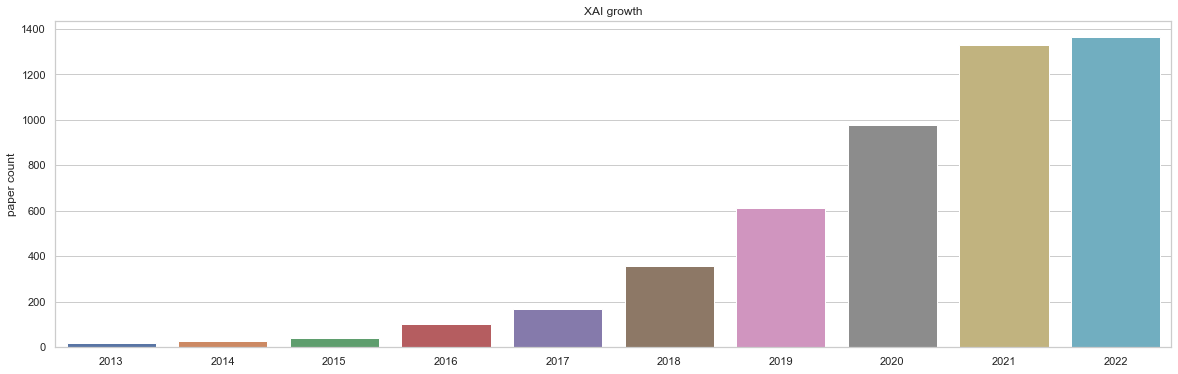

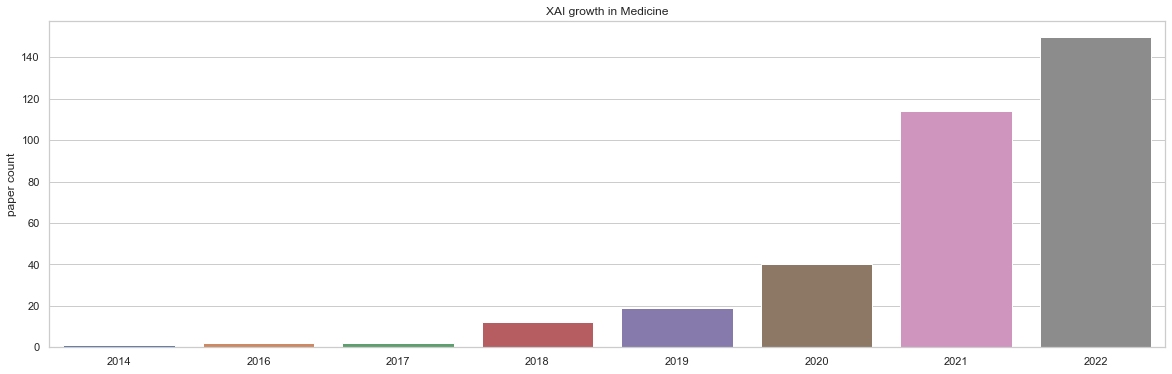

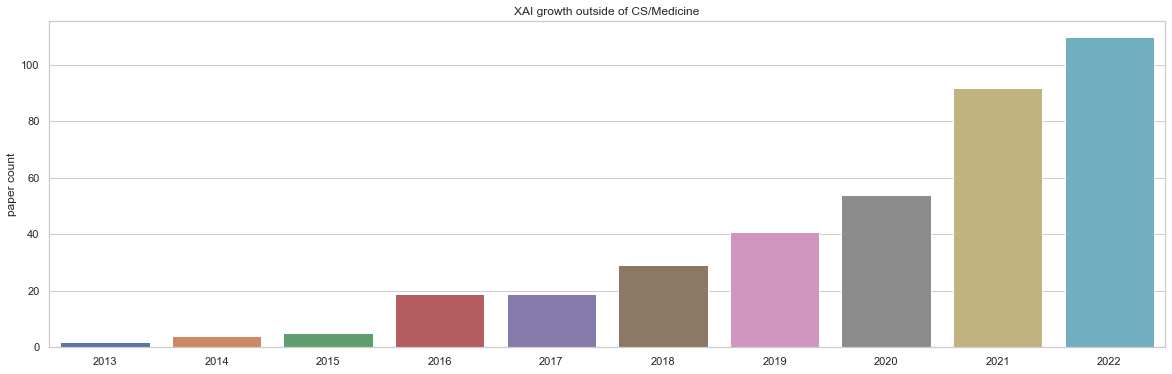

In [5]:
# All XAI-Scholar

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(20, 6))

yearly = Counter()
for pid in papers:
    field = get_field(papers[pid])
    if 'year' in papers[pid] and papers[pid]['year'] and 2023 > int(papers[pid]['year']) > 2012:
        yearly[papers[pid]['year']] += 1

yearly_df = pd.DataFrame([{'year': key, 'count': yearly[key]} for key in yearly])

sns.barplot(data=yearly_df, x="year", y='count')
ax.set(xlabel='', ylabel='paper count', title='XAI growth')
plt.savefig('figures/yearly-growth.pdf')

# Medicine only

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(20, 6))

yearly = Counter()
for pid in papers:
    field = get_field(papers[pid])
    if field != 'Medicine':
        continue
    if 'year' in papers[pid] and papers[pid]['year'] and 2023 > int(papers[pid]['year']) > 2012:
        yearly[papers[pid]['year']] += 1

yearly_df = pd.DataFrame([{'year': key, 'count': yearly[key]} for key in yearly])

sns.barplot(data=yearly_df, x="year", y='count')
ax.set(xlabel='', ylabel='paper count', title='XAI growth in Medicine')
plt.savefig('figures/yearly-growth-medicine.pdf')

# Non-CS and non-Medicine

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(20, 6))

yearly = Counter()
for pid in papers:
    field = get_field(papers[pid])
    if field == 'Computer Science' or field == 'Medicine':
        continue
    if 'year' in papers[pid] and papers[pid]['year'] and 2023 > int(papers[pid]['year']) > 2012:
        yearly[papers[pid]['year']] += 1

yearly_df = pd.DataFrame([{'year': key, 'count': yearly[key]} for key in yearly])

sns.barplot(data=yearly_df, x="year", y='count')
ax.set(xlabel='', ylabel='paper count', title='XAI growth outside of CS/Medicine')
plt.savefig('figures/yearly-growth-else.pdf')

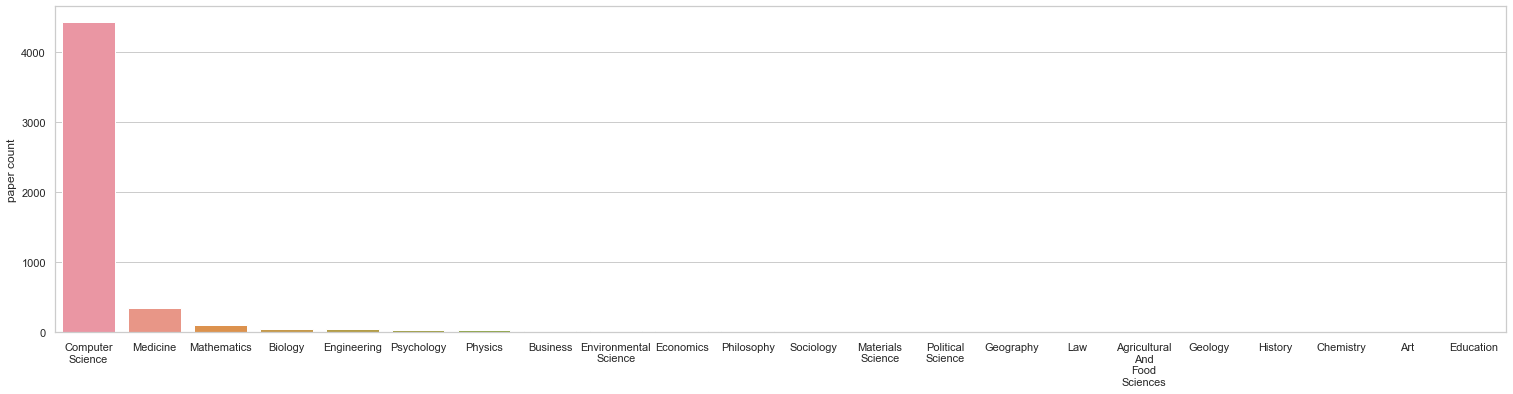

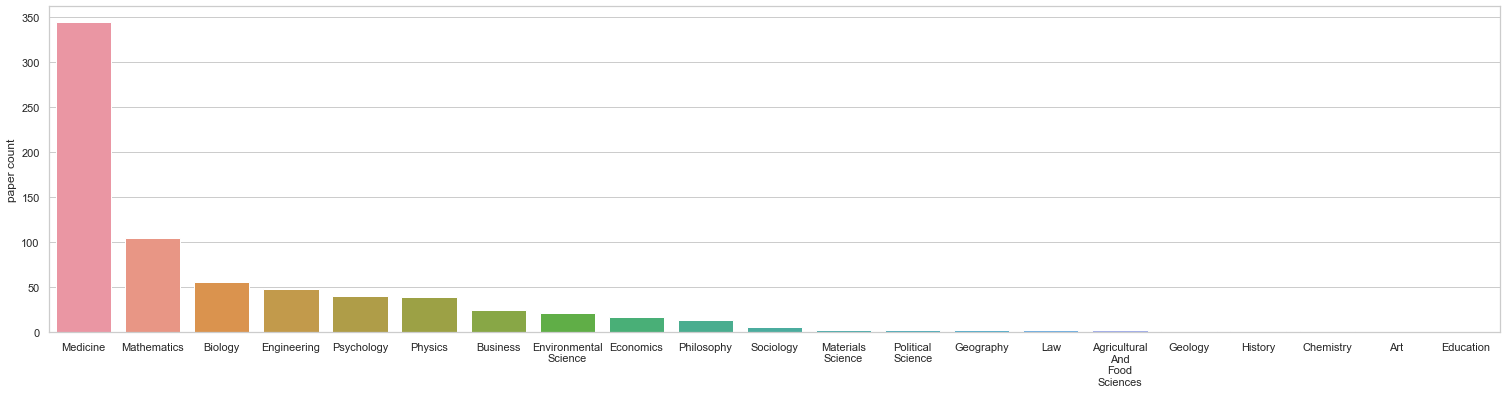

In [6]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(26, 6))

clusters = Counter()
for pid in papers:
    cluster = get_field(papers[pid])
    if cluster:
        clusters[cluster] += 1

clusters_df = pd.DataFrame([{'field': key.replace(' ','\n'), 
                          'count': clusters[key]} for key in clusters])


sns.barplot(data=clusters_df.sort_values(by='count', ascending=False), x="field", y='count')
ax.set(xlabel='', ylabel='paper count')
plt.savefig('figures/field-counts.pdf')

f, ax = plt.subplots(figsize=(26, 6))
del clusters['Computer Science']
clusters_df = pd.DataFrame([{'field': key.replace(' ','\n'), 
                          'count': clusters[key]} for key in clusters])

sns.barplot(data=clusters_df.sort_values(by='count', ascending=False), x="field", y='count')
ax.set(xlabel='', ylabel='paper count')
plt.savefig('figures/field-counts-sans-cs.pdf')

### Citation trends

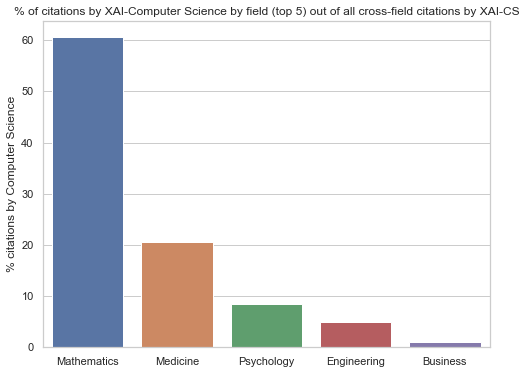

In [7]:
counts = {}
fields = set(get_field(papers[pid]) for pid in papers)

for field in fields:
    counts[field] = Counter()
# counts['Linguistics'] = Counter()

for pid in papers:
    cites = papers[pid]['citations'] if 'citations' in papers[pid] else []
    for citing_paper in cites:
        citing_pid = citing_paper['paperId']
        citing_field = get_field(citing_paper)
        cited_field = get_field(papers[pid])
        if citing_pid in papers and citing_field != cited_field and citing_field and cited_field:
            counts[citing_field][cited_field] += 1

field = 'Computer Science'
num_cites = sum(list(counts[field].values()))
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(8, 6))
counts_data = pd.DataFrame([{'field': key, f'% citations by {field}': counts[field][key]/num_cites*100} for key in counts[field] if counts[field][key]/num_cites*100 > 1])
sns.barplot(data=counts_data.sort_values(by=f'% citations by {field}', ascending=False), x="field", y=f'% citations by {field}')
ax.set(title=f'% of citations by XAI-{field} by field (top 5) out of all cross-field citations by XAI-CS', xlabel='')
plt.savefig(f'figures/percentage-cited-by-{field}.pdf')

In [8]:
# Prints a directed weighted graph in edge-list format to be used with http://graphonline.ru/en/ 
# This graph normalizes every pair of edges between two nodes to 100,
#   to show between two fields, which cites the other/is cited by the other more often.

counts = {}
fields = set(get_field(papers[pid]) for pid in papers)

for field in fields:
    counts[field] = Counter()

for pid in papers:
    cites = papers[pid]['citations'] if 'citations' in papers[pid] else []
    for citing_paper in cites:
        citing_pid = citing_paper['paperId']
        citing_field = get_field(citing_paper)
        cited_field = get_field(papers[pid])
        if citing_pid in papers and citing_field != cited_field:
            counts[citing_field][cited_field] += 1
            
for citing_field in counts:
    for cited_field in counts[citing_field]: 
        num_cites = counts[citing_field][cited_field] + counts[cited_field][citing_field]
        if num_cites < 100:
            continue
        normalized_weight = counts[citing_field][cited_field]/num_cites*100
        if normalized_weight > 1:
            print(f"{citing_field}-({normalized_weight:.0f})>{cited_field}")


Computer Science-(43)>Medicine
Computer Science-(59)>Psychology
Computer Science-(25)>Economics
Computer Science-(12)>Physics
Computer Science-(53)>Engineering
Computer Science-(5)>Biology
Computer Science-(80)>Mathematics
Computer Science-(18)>Business
Economics-(75)>Computer Science
Mathematics-(20)>Computer Science
Medicine-(57)>Computer Science
Physics-(88)>Computer Science
Business-(82)>Computer Science
Biology-(95)>Computer Science
Psychology-(41)>Computer Science
Engineering-(47)>Computer Science


In [9]:
# Citation graph where all outgoing edges from a particular field are normalized to 100%

counts = {}
fields = set(get_field(papers[pid]) for pid in papers)

for field in fields:
    counts[field] = Counter()

for pid in papers:
    cites = papers[pid]['citations'] if 'citations' in papers[pid] else []
    for citing_paper in cites:
        citing_pid = citing_paper['paperId']
        citing_field = get_field(citing_paper)
        cited_field = get_field(papers[pid])
        if citing_field == 'Computer Science' or cited_field == 'Computer Science':
            continue
        if citing_pid in papers and citing_field != cited_field and citing_field and cited_field:
            counts[citing_field][cited_field] += 1
            
for citing_field in counts:
    num_cites = sum(list(counts[citing_field].values()))
    if num_cites > 20:
        for cited_field,cite_count in counts[citing_field].most_common(3): 
            normalized_weight = counts[citing_field][cited_field]/num_cites*100
            if normalized_weight > 0:
                print(num_cites, f"{citing_field}-({normalized_weight:.0f})>{cited_field}")


90 Medicine-(77)>Mathematics
90 Medicine-(9)>Psychology
90 Medicine-(3)>Engineering
25 Biology-(44)>Medicine
25 Biology-(36)>Mathematics
25 Biology-(12)>Psychology
21 Psychology-(48)>Mathematics
21 Psychology-(38)>Medicine
21 Psychology-(5)>Law


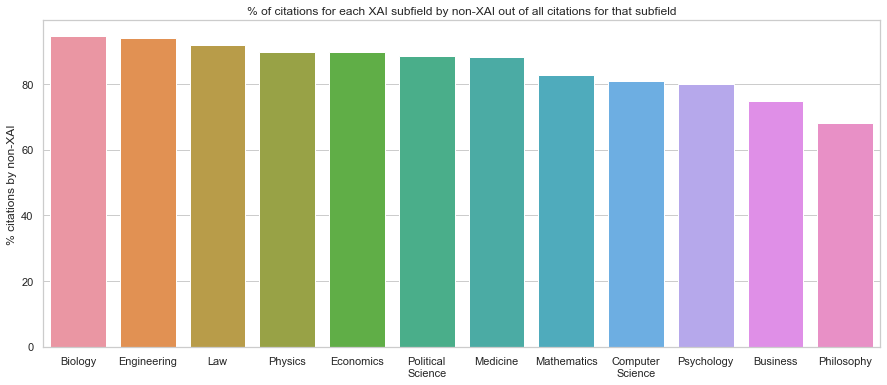

In [10]:
counts = {}
fields = set(get_field(papers[pid]) for pid in papers)

counts_by_all = Counter()
counts_by_outside = Counter()

for pid in papers:
    cites = papers[pid]['citations'] if 'citations' in papers[pid] else []
    for citing_paper in cites:
        citing_pid = citing_paper['paperId']
        citing_field = get_field(citing_paper)
        cited_field = get_field(papers[pid])
        if citing_pid not in papers and citing_field and cited_field:
            counts_by_outside[cited_field] += 1
        if citing_field and cited_field:
            counts_by_all[cited_field] += 1

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 6))
counts_data = pd.DataFrame([{'field': field.replace(' ', '\n'), f'% citations by non-XAI': counts_by_outside[field]/counts_by_all[field]*100} for field in counts_by_outside if counts_by_all[field] > 100])
counts_data = counts_data.sort_values(by='% citations by non-XAI', ascending=False)
sns.barplot(data=counts_data, x="field", y=f'% citations by non-XAI')
ax.set(title=f'% of citations for each XAI subfield by non-XAI out of all citations for that subfield', xlabel='')
plt.savefig(f'figures/percentage-cited-by-non-XAI.pdf')


Top cited papers in Computer Science by XAI-Computer Science.
1.4%	“Why Should I Trust You?”: Explaining the Predictions of Any Classifier
1.0%	A Unified Approach to Interpreting Model Predictions
0.6%	Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps
0.6%	Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization
0.6%	Axiomatic Attribution for Deep Networks
0.5%	Visualizing and Understanding Convolutional Networks
0.5%	Towards A Rigorous Science of Interpretable Machine Learning
0.5%	On Pixel-Wise Explanations for Non-Linear Classifier Decisions by Layer-Wise Relevance Propagation
0.4%	Explanation in Artificial Intelligence: Insights from the Social Sciences
0.4%	Learning Important Features Through Propagating Activation Differences

Top cited papers in Economics by XAI-Computer Science.
14.6%	A Value for n-person Games
1.9%	The Shapley value : essays in honor of Lloyd S. Shapley
1.8%	Human Decisions and Machine Predict

Top cited papers in Psychology by XAI-Computer Science.
1.0%	The structure and function of explanations
1.0%	The Role of Explanations on Trust and Reliance in Clinical Decision Support Systems
0.8%	Explanation and understanding.
0.7%	False Positives, False Negatives, and False Analyses: A Rejoinder to "Machine Bias: There's Software Used across the Country to Predict Future Criminals. and It's Biased against Blacks"
0.6%	A unified view of gradient-based attribution methods for Deep Neural Networks
0.6%	Conversational Processes and Causal Explanation
0.6%	When Explanations Lie: Why Many Modified BP Attributions Fail
0.5%	Explanation and Abductive Inference
0.4%	Causal Inference in Statistics: A Primer
0.4%	Humans and Automation: Use, Misuse, Disuse, Abuse

Top cited papers in Sociology by XAI-Computer Science.
3.1%	Big Data's Disparate Impact
1.3%	Dialogical Models of Explanation
1.1%	Logic and Conversation
1.1%	An Integrative Model Of Organizational Trust
1.0%	Fairness in Machine Learn

Top cited papers in Physics by XAI-Medicine.
1.8%	Deep learning for electroencephalogram (EEG) classification tasks: a review
1.8%	Using machine learning to predict radiation pneumonitis in patients with stage I non-small cell lung cancer treated with stereotactic body radiation therapy
1.8%	A General-Purpose Machine Learning Framework for Predicting Properties of Inorganic Materials
1.8%	New tolerance factor to predict the stability of perovskite oxides and halides
0.9%	Deep learning the slow modes for rare events sampling
0.9%	Autonomous artificial intelligence discovers mechanisms of molecular self-organization in virtual experiments
0.9%	Exact Topology of the Dynamic Probability Surface of an Activated Process by Persistent Homology.
0.9%	Data-Driven Collective Variables for Enhanced Sampling.
0.9%	Machine learning approaches for analyzing and enhancing molecular dynamics simulations.
0.9%	Artificial Intelligence Assists Discovery of Reaction Coordinates and Mechanisms from Molecul

Top cited papers in Computer Science by XAI-Biology.
1.4%	A Unified Approach to Interpreting Model Predictions
1.1%	Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps
0.9%	XGBoost: A Scalable Tree Boosting System
0.8%	From local explanations to global understanding with explainable AI for trees
0.8%	Learning Important Features Through Propagating Activation Differences
0.8%	Axiomatic Attribution for Deep Networks
0.8%	Adam: A Method for Stochastic Optimization
0.7%	Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead
0.7%	“Why Should I Trust You?”: Explaining the Predictions of Any Classifier
0.6%	Scikit-learn: Machine Learning in Python

Top cited papers in Mathematics by XAI-Biology.
3.8%	Visualizing Data using t-SNE
3.2%	Greedy function approximation: A gradient boosting machine.
1.3%	An axiomatic approach to the concept of interaction among players in cooperative games
1.3%	Contro

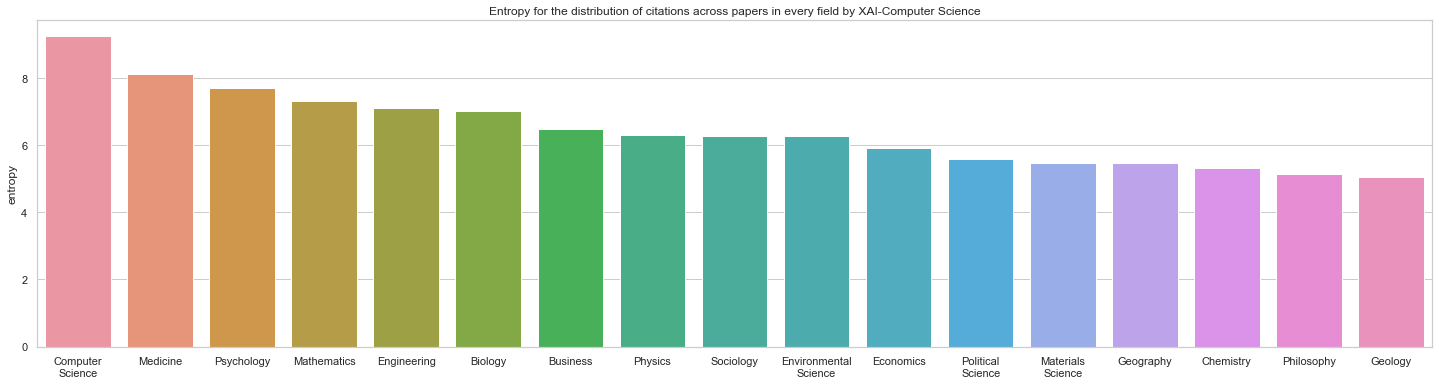

In [11]:
from scipy.stats import entropy
fields = set(get_field(papers[pid]) for pid in papers)
all_refs = {}

for citing_field in fields:
    entropies = []
    for cited_field in fields:
        if not citing_field or not cited_field:
            continue
        counts = Counter()
        for pid in papers:
            if get_field(papers[pid]) != citing_field:
                continue
    
            refs = papers[pid]['references'] if 'references' in papers[pid] and papers[pid]['references'] else []
            for ref in refs:
                if ref['paperId'] not in all_refs:
                    all_refs[ref['paperId']] = ref
                if get_field(ref) != cited_field:
                    continue
                    
                counts[ref['paperId']] += 1
        if len(counts) != 0:
            num_cites = sum(list(counts.values()))
            if num_cites < 100:
                continue
            print(f'Top cited papers in {cited_field} by XAI-{citing_field}.')
            sum_cites = 0
            for pid2,c in counts.most_common(10):
                title = all_refs[pid2]['title'].replace('\n', ' ')
                print(f"{c/num_cites*100:.1f}%\t{title}")
                sum_cites += c/num_cites*100
                
            print('')
            entropies.append({'field': cited_field.replace(' ', '\n'), 'entropy': entropy(list(counts.values()))})
    
    if citing_field == 'Computer Science':
        sns.set_theme(style="whitegrid")
        f, ax = plt.subplots(figsize=(25, 6))
        entropies = pd.DataFrame(entropies).sort_values(by='entropy', ascending=False)
        sns.barplot(data=entropies, x="field", y='entropy')
        
        ax.set(title=f'Entropy for the distribution of citations across papers in every field by XAI-{citing_field}', xlabel='')
        plt.savefig(f'figures/citation-entropy-{citing_field}.pdf')

In [12]:
fields = set(get_field(papers[pid]) for pid in papers)
all_cites = {}

for field in fields:
    counts = Counter()
    for pid in papers:
        if get_field(papers[pid]) != field:
            continue

        cites = papers[pid]['citations'] if 'citations' in papers[pid] and papers[pid]['citations'] else []
        for cite in cites:
            if cite['paperId'] not in all_cites:
                all_cites[ref['paperId']] = cite
            if get_field(cite) == field:# or cite['paperId'] not in papers:
                continue

            counts[pid] += 1
            
    num_cites = sum(list(counts.values()))
    if num_cites < 10:
        continue
    print(f'Top cited papers in XAI-{field} by papers outside of {field}.')
    for pid2,c in counts.most_common(10):
        print(f"{c/num_cites*100:.1f}%\t{papers[pid2]['title']}")
    print('')

Top cited papers in XAI-Computer Science by papers outside of Computer Science.
1.9%	Detection of Influential Observation in Linear Regression
1.8%	Conditional variable importance for random forests
1.7%	To Explain or to Predict
1.7%	Bias in random forest variable importance measures: Illustrations, sources and a solution
1.5%	Illuminating the “black box”: a randomization approach for understanding variable contributions in artificial neural networks
1.4%	From local explanations to global understanding with explainable AI for trees
1.4%	On the interpretation of weight vectors of linear models in multivariate neuroimaging
1.4%	An accurate comparison of methods for quantifying variable importance in artificial neural networks using simulated data
1.3%	Permutation importance: a corrected feature importance measure
1.2%	How the machine ‘thinks’: Understanding opacity in machine learning algorithms

Top cited papers in XAI-Economics by papers outside of Economics.
51.5%	The Right to Explana

In [13]:
fields = set(get_field(papers[pid]) for pid in papers)

for citing_field in fields:
    for cited_field in fields:
        if not citing_field or not cited_field:
            continue
        counts = Counter()
        for pid in papers:
            if get_field(papers[pid]) != cited_field:
                continue
    
            cites = papers[pid]['citations'] if 'citations' in papers[pid] and papers[pid]['citations'] else []
            for cite in cites:
                if get_field(cite) != citing_field:
                    continue
                    
                counts[pid] += 1
                
        if len(counts) != 0:
            num_cites = sum(list(counts.values()))
            if num_cites < 100:
                continue
            print(f'Top cited XAI-{cited_field} papers by {citing_field}.')
            sum_cites = 0
            for pid2,c in counts.most_common(10):
                title = papers[pid2]['title'].replace('\n', ' ')
                print(f"{c/num_cites*100:.1f}%\t{title}")
                sum_cites += c/num_cites*100
                
            print('')

Top cited XAI-Computer Science papers by Computer Science.
0.5%	DREBIN: Effective and Explainable Detection of Android Malware in Your Pocket
0.5%	Adversarial Machine Learning at Scale
0.5%	Intriguing properties of neural networks
0.5%	Object Detectors Emerge in Deep Scene CNNs
0.5%	InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets
0.5%	Network Dissection: Quantifying Interpretability of Deep Visual Representations
0.5%	Understanding deep learning requires rethinking generalization
0.5%	Interpretable Explanations of Black Boxes by Meaningful Perturbation
0.5%	Understanding deep image representations by inverting them
0.5%	Show, Attend and Tell: Neural Image Caption Generation with Visual Attention

Top cited XAI-Economics papers by Computer Science.
55.0%	The Right to Explanation, Explained
35.0%	The Shapley value
3.6%	Predicting , explaining , and understanding risk of long-term unemployment
2.1%	Paving the way towards counterfactual 

Top cited XAI-Computer Science papers by Mathematics.
3.6%	Detection of Influential Observation in Linear Regression
3.4%	Improving the interpretability of TSK fuzzy models by combining global learning and local learning
3.0%	Analysis of interpretability-accuracy tradeoff of fuzzy systems by multiobjective fuzzy genetics-based machine learning
1.8%	To Explain or to Predict
1.6%	Conditional variable importance for random forests
1.6%	An accurate comparison of methods for quantifying variable importance in artificial neural networks using simulated data
1.6%	Illuminating the “black box”: a randomization approach for understanding variable contributions in artificial neural networks
1.6%	Bias in random forest variable importance measures: Illustrations, sources and a solution
1.5%	Opening the Black Box of Deep Neural Networks via Information
1.5%	Are artificial neural networks black boxes?

Top cited XAI-Mathematics papers by Mathematics.
16.2%	Designing fuzzy inference systems from data:

Top cited XAI-Computer Science papers by Materials Science.
9.4%	An accurate comparison of methods for quantifying variable importance in artificial neural networks using simulated data
7.0%	Illuminating the “black box”: a randomization approach for understanding variable contributions in artificial neural networks
2.6%	From local explanations to global understanding with explainable AI for trees
2.4%	A Unified Approach to Interpreting Model Predictions
2.4%	Detection of Influential Observation in Linear Regression
1.7%	Methods for interpreting and understanding deep neural networks
1.7%	U-Net: Convolutional Networks for Biomedical Image Segmentation
1.7%	Bias in random forest variable importance measures: Illustrations, sources and a solution
1.7%	Simplifying decision trees
1.6%	Permutation importance: a corrected feature importance measure

Top cited XAI-Computer Science papers by Physics.
3.5%	Kernel methods for interpretable machine learning of order parameters
2.5%	U-Net: Convolut

Top cited XAI-Computer Science papers by Psychology.
5.5%	On the interpretation of weight vectors of linear models in multivariate neuroimaging
3.5%	Detection of Influential Observation in Linear Regression
2.7%	To Explain or to Predict
1.6%	How the machine ‘thinks’: Understanding opacity in machine learning algorithms
1.5%	Legibility and predictability of robot motion
1.3%	Interpretable Classifiers for fMRI Improve Prediction of Purchases
1.3%	Explanations From Intelligent Systems: Theoretical Foundations and Implications for Practice
1.2%	The Epistemology of a Rule-Based Expert System - A Framework for Explanation
1.1%	Conditional variable importance for random forests
1.0%	Explaining collaborative filtering recommendations

Top cited XAI-Mathematics papers by Psychology.
51.2%	Simplicity and probability in causal explanation
8.7%	Causes and Explanations: A Structural-Model Approach. Part II: Explanations
6.3%	Empirical characterization of random forest variable importance measures
4

Top cited XAI-Computer Science papers by Political Science.
8.0%	Reading Tea Leaves: How Humans Interpret Topic Models
7.2%	How the machine ‘thinks’: Understanding opacity in machine learning algorithms
6.7%	Why a Right to Explanation of Automated Decision-Making Does Not Exist in the General Data Protection Regulation
6.0%	SLAVE TO THE ALGORITHM ? WHY A ‘ RIGHT TO AN EXPLANATION ’ IS PROBABLY NOT THE REMEDY YOU ARE LOOKING FOR
2.6%	Counterfactual Explanations Without Opening the Black Box: Automated Decisions and the GDPR
2.5%	The EU General Data Protection Regulation (GDPR)
2.3%	Accountability of AI Under the Law: The Role of Explanation
2.1%	Transparency in Algorithmic and Human Decision-Making: Is There a Double Standard?
1.7%	Explaining collaborative filtering recommendations
1.2%	Explanations From Intelligent Systems: Theoretical Foundations and Implications for Practice

Top cited XAI-Engineering papers by Political Science.
88.2%	The Black Box Society: The Secret Algorithms Tha

In [14]:
fields = set(get_field(papers[pid]) for pid in papers)

for citing_field in fields:
    for cited_field in fields:
        if not citing_field or not cited_field:
            continue
        counts = Counter()
        for pid in papers:
            if get_field(papers[pid]) != cited_field:
                continue
    
            cites = papers[pid]['citations'] if 'citations' in papers[pid] and papers[pid]['citations'] else []
            for cite in cites:
                if cite['paperId'] not in papers or get_field(cite) != citing_field:
                    continue
                    
                counts[pid] += 1
                
        if len(counts) != 0:
            num_cites = sum(list(counts.values()))
            if num_cites < 100:
                continue
            print(f'Top cited XAI-{cited_field} papers by XAI-{citing_field}.')
            sum_cites = 0
            for pid2,c in counts.most_common(10):
                title = papers[pid2]['title'].replace('\n', ' ')
                print(f"{c/num_cites*100:.1f}%\t{title}")
                sum_cites += c/num_cites*100
                
            print('')

Top cited XAI-Computer Science papers by XAI-Computer Science.
0.9%	Counterfactual Explanations Without Opening the Black Box: Automated Decisions and the GDPR
0.9%	Sanity Checks for Saliency Maps
0.8%	Interpretable Explanations of Black Boxes by Meaningful Perturbation
0.8%	SmoothGrad: removing noise by adding noise
0.7%	Towards A Rigorous Science of Interpretable Machine Learning
0.7%	Learning Important Features Through Propagating Activation Differences
0.6%	How to Explain Individual Classification Decisions
0.6%	Peeking Inside the Black-Box: A Survey on Explainable Artificial Intelligence (XAI)
0.6%	A Survey of Methods for Explaining Black Box Models
0.6%	Evaluating the Visualization of What a Deep Neural Network Has Learned

Top cited XAI-Mathematics papers by XAI-Computer Science.
15.2%	Interpretability Beyond Feature Attribution: Quantitative Testing with Concept Activation Vectors (TCAV)
8.9%	European Union Regulations on Algorithmic Decision-Making and a "Right to Explanation"

Top cited XAI-Computer Science papers by XAI-Psychology.
2.3%	Explainable AI: Beware of Inmates Running the Asylum Or: How I Learnt to Stop Worrying and Love the Social and Behavioural Sciences
1.9%	Why and why not explanations improve the intelligibility of context-aware intelligent systems
1.9%	Trends and Trajectories for Explainable, Accountable and Intelligible Systems: An HCI Research Agenda
1.4%	Metrics for Explainable AI: Challenges and Prospects
1.4%	A Survey of Evaluation Methods and Measures for Interpretable Machine Learning
1.4%	Explaining nonlinear classification decisions with deep Taylor decomposition
1.4%	Explanation and Justification in Machine Learning : A Survey Or
1.4%	Explanation in Artificial Intelligence: Insights from the Social Sciences
1.4%	Too much, too little, or just right? Ways explanations impact end users' mental models
1.4%	Explanations From Intelligent Systems: Theoretical Foundations and Implications for Practice

Top cited XAI-Computer Science papers

### Collaboration trends

In [15]:
# We define the field of study of an author as the field of the majority of their papers

def all_pairs(l):
    if not hasattr(l, "__getitem__"):
        l = list(l)
    l = sorted(l)
    return [(a, b) for idx, a in enumerate(l) for b in l[idx + 1:]]

for aid in tqdm(authors):
    count_fields = Counter()
    for paper in authors[aid]['papers'] if 'papers' in authors[aid] else []:
        count_fields[get_field(paper)] += 1
    authors[aid]['fields'] = count_fields
    

  0%|          | 0/14460 [00:00<?, ?it/s]

In [16]:
# Collaboration graph as an undirected weighted graph 
# = how many collaborations are between fields A-B out of all papers with collaborations

collabs = Counter()

norm = 0

for pid in papers:
    fields = set()
    for author in papers[pid]['authors'] if 'authors' in papers[pid] else []:
        aid = author['authorId']
        if aid and aid in authors and authors[aid]:
            author_fields = authors[aid]['fields'].most_common(1)
            if author_fields and author_fields[0][0]:
                field = author_fields[0][0]
                fields.add(field)
    if len(fields) > 1:
        # collab
        norm += 1
        for f1, f2 in all_pairs(fields):
            collabs[(f1,f2)] += 1

for (f1, f2), c in collabs.most_common(20):
    if c/norm*100 < 3:
        continue
    print(f'{f1}-({c/norm*100:.2f})-{f2}')
    

Computer Science-(47.62)-Medicine
Biology-(10.21)-Computer Science
Computer Science-(8.64)-Physics
Computer Science-(7.82)-Mathematics
Computer Science-(7.53)-Psychology
Computer Science-(6.26)-Engineering
Biology-(6.04)-Medicine
Computer Science-(5.29)-Environmental Science
Computer Science-(4.55)-Materials Science
Computer Science-(3.87)-Economics
Business-(3.65)-Computer Science
Chemistry-(3.50)-Computer Science


In [17]:
# Same as above but without CS

collabs = Counter()

norm = 0

for pid in papers:
    fields = set()
    for author in papers[pid]['authors'] if 'authors' in papers[pid] else []:
        aid = author['authorId']
        if aid and aid in authors and authors[aid]:
            author_fields = authors[aid]['fields'].most_common(1)
            if author_fields and author_fields[0][0]:
                field = author_fields[0][0]
                if field == 'Computer Science':
                    continue
                fields.add(field)
    if len(fields) > 1:
        # collab
        norm += 1
        for f1, f2 in all_pairs(fields):
            collabs[(f1,f2)] += 1

for (f1, f2), c in collabs.most_common(20):
#     norm = sum(list(collabs.values()))
    if c/norm*100 < 3:
        continue
    print(f'{f1}-({c/norm*100:.2f})-{f2}')
    

Biology-(23.48)-Medicine
Chemistry-(10.43)-Medicine
Medicine-(8.99)-Physics
Medicine-(8.12)-Psychology
Engineering-(6.96)-Medicine
Mathematics-(5.51)-Medicine
Environmental Science-(4.93)-Medicine
Environmental Science-(4.64)-Geology
Materials Science-(4.35)-Medicine
Biology-(4.06)-Chemistry
Engineering-(3.77)-Materials Science


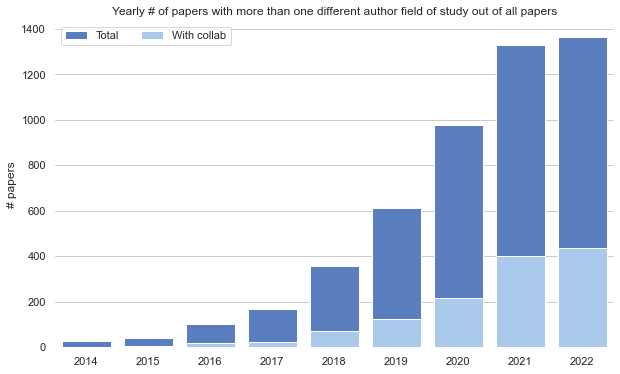

In [20]:

yearly_collabs = Counter()
yearly_papers = Counter()

norm = 0

for pid in papers:
    fields = set()
    year = papers[pid]['year'] if 'year' in papers[pid] else None
    if not year:
        continue
    for author in papers[pid]['authors'] if 'authors' in papers[pid] else []:
        aid = author['authorId']
        if aid and aid in authors and authors[aid]:
            author_fields = authors[aid]['fields'].most_common(1)
            if author_fields and author_fields[0][0]:
                field = author_fields[0][0]
                fields.add(field)
    if len(fields) > 1:
        # collab
        yearly_collabs[year] += 1
    yearly_papers[year] += 1

    
# sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 6))


sns.set_color_codes("muted")
# sns.barplot(x="alcohol", y="abbrev", data=crashes,
#             label="Alcohol-involved", color="b")
counts_data = pd.DataFrame([{'year': year, f'# papers': yearly_papers[year]} for year in yearly_papers if 2023 > year > 2013])
sns.barplot(data=counts_data, x="year", y=f'# papers', label='Total', color="b")


sns.set_color_codes("pastel")
# sns.barplot(x="total", y="abbrev", data=crashes,
#             label="Total", color="b")
counts_data = pd.DataFrame([{'year': year, f'# papers': yearly_collabs[year]} for year in yearly_papers if 2023 > year > 2013])
sns.barplot(data=counts_data, x="year", y=f'# papers', label='With collab', color="b")

ax.legend(ncol=2, loc="upper left", frameon=True)
sns.despine(left=True, bottom=True)

ax.set(title=f'Yearly # of papers with more than one different author field of study out of all papers', xlabel='')
plt.savefig(f'figures/collab-growth2.pdf')

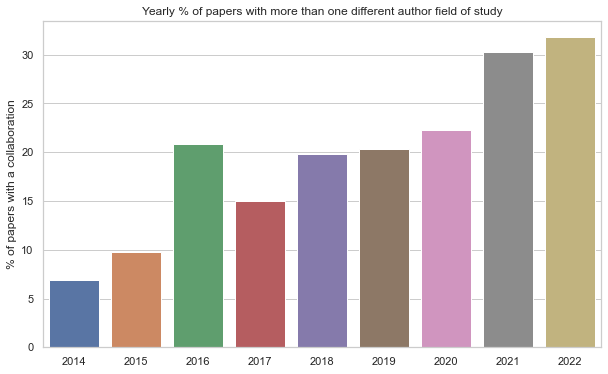

In [21]:

yearly_collabs = Counter()
yearly_papers = Counter()

norm = 0

for pid in papers:
    fields = set()
    year = papers[pid]['year'] if 'year' in papers[pid] else None
    if not year:
        continue
    for author in papers[pid]['authors'] if 'authors' in papers[pid] else []:
        aid = author['authorId']
        if aid and aid in authors and authors[aid]:
            author_fields = authors[aid]['fields'].most_common(1)
            if author_fields and author_fields[0][0]:
                field = author_fields[0][0]
                fields.add(field)
    if len(fields) > 1:
        # collab
        yearly_collabs[year] += 1
    yearly_papers[year] += 1

    
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 6))
counts_data = pd.DataFrame([{'year': year, f'% of papers with a collaboration': yearly_collabs[year]/yearly_papers[year]*100} for year in yearly_papers if 2023 > year > 2013])
sns.barplot(data=counts_data, x="year", y=f'% of papers with a collaboration')

ax.set(title=f'Yearly % of papers with more than one different author field of study', xlabel='')
plt.savefig(f'figures/collab-growth.pdf')

